In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [4]:
def crop_black(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    x_nonzero = np.nonzero(gray[0])
    y_nonzero = np.nonzero(gray[:, gray.shape[1]-1])
    return img[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):]

In [95]:
def warpImages_l_to_r(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    list_of_points_2 = cv.perspectiveTransform(temp_points, H)

    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max-x_min, y_max-y_min) )
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

In [161]:
def warpImages_r_to_l(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    list_of_points_2 = cv.perspectiveTransform(temp_points, H)

    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
    [x_max2, y_max2] = np.int32(list_of_points_2.max(axis=0).ravel() + 0.5)
    print(list_of_points)

    translation_dist = [-x_min, -y_min]
    print(translation_dist)
    print([x_max2, y_max2] )

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    
    result_img = np.zeros((np.max((y_max2-y_min, rows1)),x_max2-x_min+cols1,3), np.uint8)
    
    output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max2-x_min, y_max2-y_min) )
    print(output_img.shape)
    # (x_max-x_min, y_max-y_min) 
    # output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
    # res_img = np.zeros((rows1+translation_dist[1],cols1+translation_dist[0],3), np.uint8)
    # res_img[0:rows1, 0:cols1] = img1
    # res_img[rows1:rows1+translation_dist[1], cols1:cols1+translation_dist[0]] = output_img
    result_img[0:y_max2-y_min, 0:x_max2-x_min] = output_img

    return result_img

In [94]:
def concat_images(img1, img2, method):
    orb = cv.ORB_create(nfeatures=2000)

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv.BFMatcher_create(cv.NORM_HAMMING)

    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    all_matches = []
    for m, n in matches:
        all_matches.append(m)

    good = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good.append(m)
            
    MIN_MATCH_COUNT = 10

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

        M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

        result = method(img1, img2, M)
        
        return result
        
    return None

## Building1

[[[   0.          0.      ]]

 [[   0.        480.      ]]

 [[ 640.        480.      ]]

 [[ 640.          0.      ]]

 [[-317.29504   -59.065376]]

 [[-373.58722   516.5761  ]]

 [[ 354.23148   497.56586 ]]

 [[ 382.01645    54.055138]]]
[374, 59]
[382, 517]
(576, 756, 3)


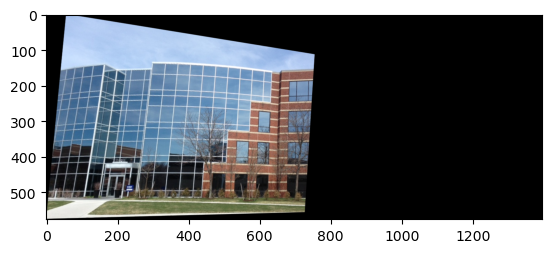

In [162]:
p = pathlib.Path('./building1')

it = p.iterdir()

img_path = next(it)
img1 = cv.imread(str(img_path))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img_path = next(it)

img2 = cv.imread(str(img_path))
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_r_to_l(i1, i2, M))
    

if img1 is None:
    print("Not enought match keypoints")

plt.imshow(img1)
plt.show()

(576, 1014, 3)


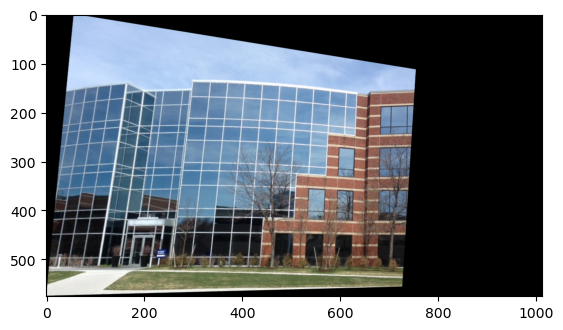

(667, 1172, 3)


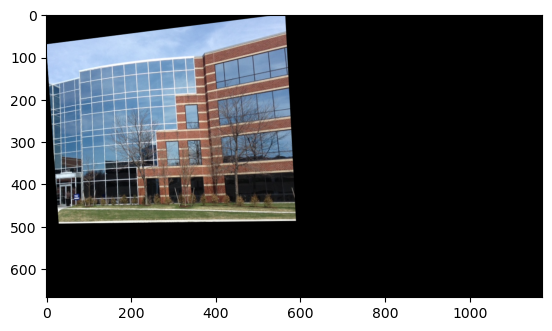

(817, 1544, 3)


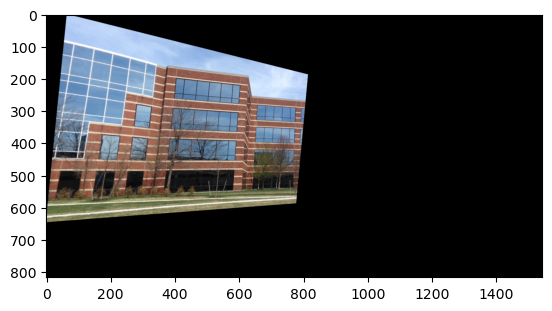

(992, 1993, 3)


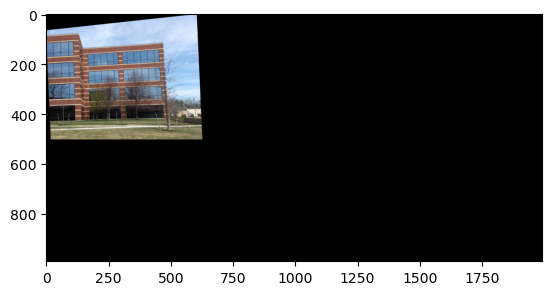

In [83]:
p = pathlib.Path('./building1')

it = p.iterdir()

img_path = next(it)
img1 = cv.imread(str(img_path))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

for img_path in it:
    img2 = cv.imread(str(img_path))
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    
    img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_r_to_l(i1, i2, M))
       
    
    if img1 is None:
        print("Not enought match keypoints")
        break
    
    plt.imshow(img1)
    plt.show()

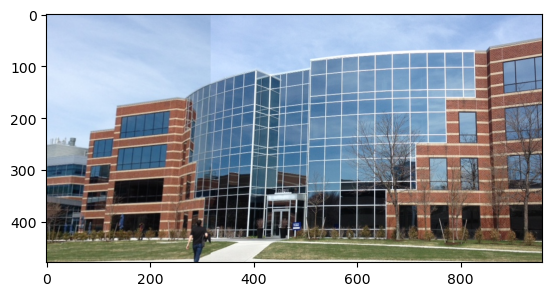

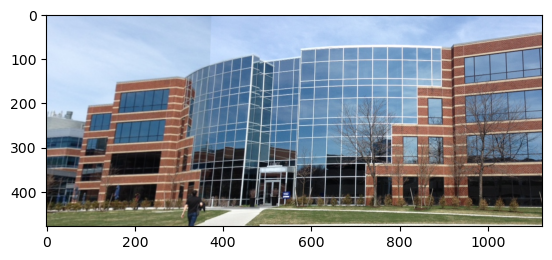

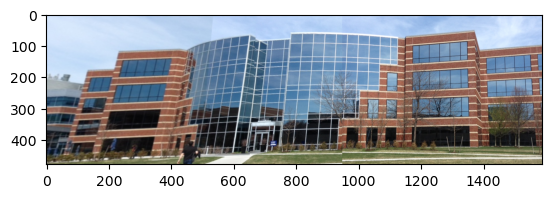

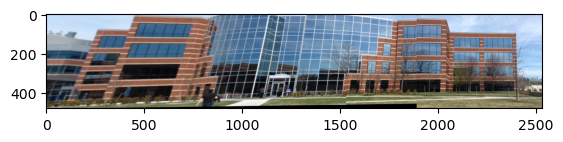

In [96]:
p = pathlib.Path('./building1')

it = p.iterdir()

img_path = next(it)
img1 = cv.imread(str(img_path))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

for img_path in it:
    img2 = cv.imread(str(img_path))
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    
    img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_l_to_r(i2, i1, M))
    
    img1 = crop_black(img1)
       
    if img1 is None:
        print("Not enought match keypoints")
        break
    
    plt.imshow(img1)
    plt.show()

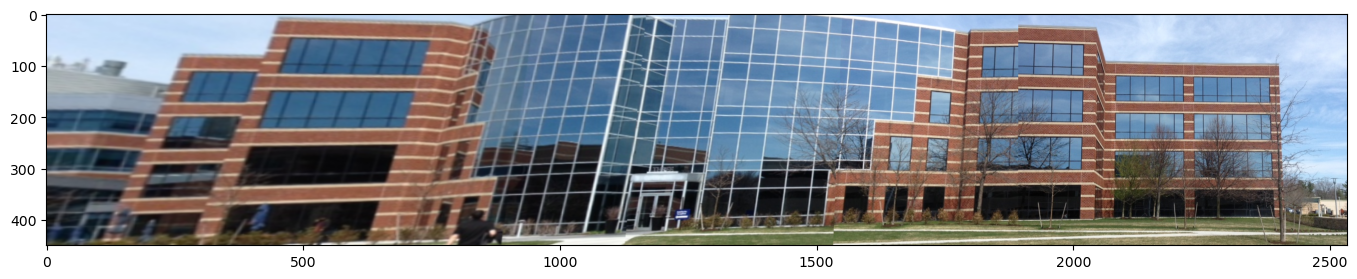

In [98]:
result = img1[:450]

plt.figure(figsize=(24, 3))

plt.imshow(result)

## Building2

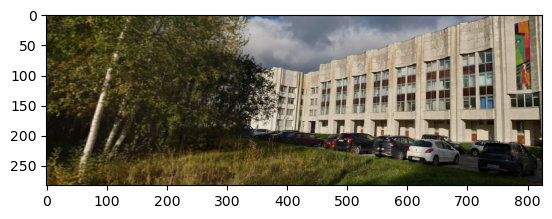

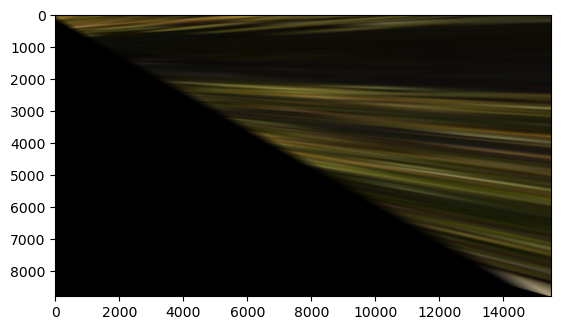

Not enought match keypoints


In [101]:
p = pathlib.Path('./building2')

it = p.iterdir()

img_path = next(it)
img1 = cv.imread(str(img_path))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img1 = cv.resize(img1, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)

for img_path in it:
    img2 = cv.imread(str(img_path))
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    img2 = cv.resize(img2, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)
    
    
    img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_l_to_r(i2, i1, M))
       
    if img1 is None:
        print("Not enought match keypoints")
        break
    
    img1 = crop_black(img1)
    
    plt.imshow(img1)
    plt.show()

In [133]:
p = pathlib.Path('./building2')

it = p.iterdir()

img_path = next(it)
img1 = cv.imread(str(img_path))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img1 = cv.resize(img1, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)

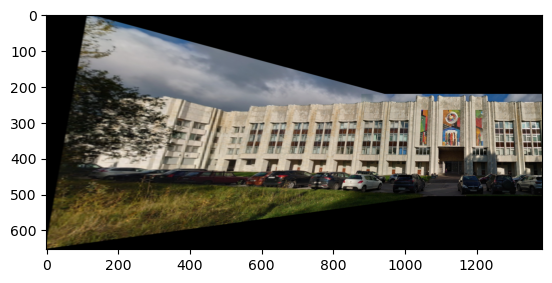

In [134]:
img_path = next(it)
img2 = cv.imread(str(img_path))
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img2 = cv.resize(img2, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)


img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_l_to_r(i2, i1, M))
    
if img1 is None:
    print("Not enought match keypoints")
plt.imshow(img1)
plt.show()

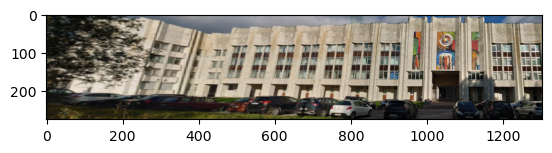

In [139]:
img1= img1[220:495, 80:]
plt.imshow(img1)
plt.show()

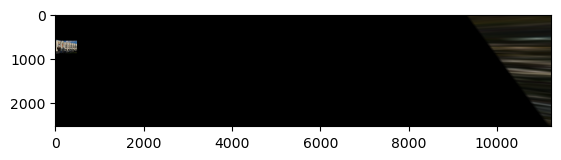

In [140]:
img_path = next(it)
img2 = cv.imread(str(img_path))
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img2 = cv.resize(img2, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)


img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_l_to_r(i2, i1, M))
    
if img1 is None:
    print("Not enought match keypoints")

plt.imshow(img1)
plt.show()

## Building3

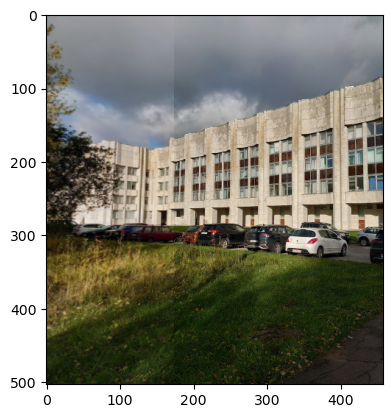

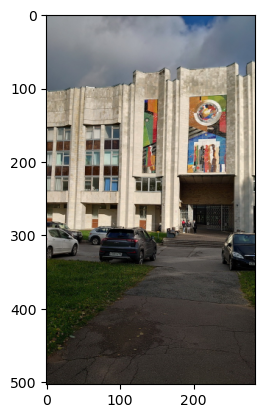

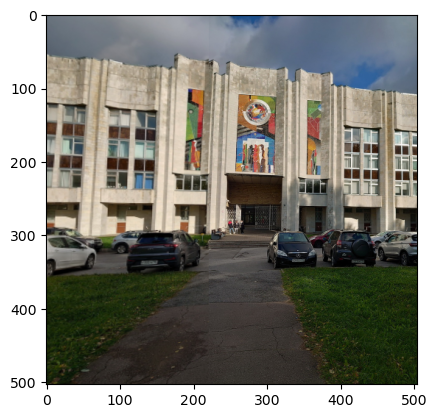

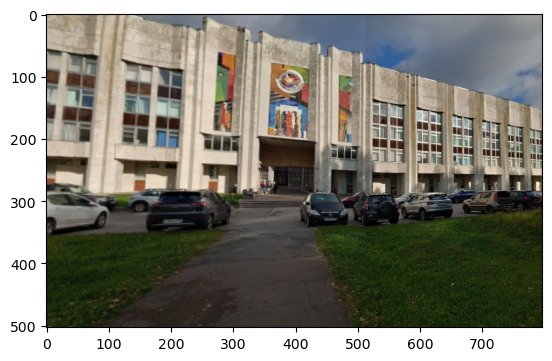

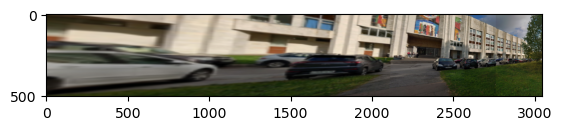

In [87]:
p = pathlib.Path('./building3')

it = p.iterdir()

img_path = next(it)
img1 = cv.imread(str(img_path))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img1 = cv.resize(img1, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)

for img_path in it:
    img2 = cv.imread(str(img_path))
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
    img2 = cv.resize(img2, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)
    
    img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_l_to_r(i2, i1, M))
       
    if img1 is None:
        print("Not enought match keypoints")
        break
    
    plt.imshow(img1)
    plt.show()

In [91]:
p = pathlib.Path('./building3')

it = p.iterdir()

img_path = next(it)
img1 = cv.imread(str(img_path))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img1 = cv.resize(img1, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)

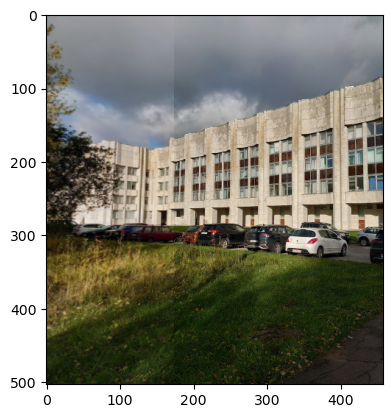

In [92]:
img_path = next(it)
img2 = cv.imread(str(img_path))
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img2 = cv.resize(img2, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)

img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_l_to_r(i2, i1, M))
img1 = crop_black(img1)
if img1 is None:
    print("Not enought match keypoints")

plt.imshow(img1)
plt.show()

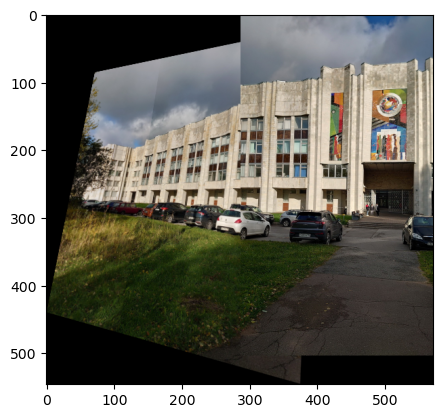

In [93]:
img_path = next(it)
img2 = cv.imread(str(img_path))
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img2 = cv.resize(img2, None, fx=0.5, fy=0.5, interpolation=cv.INTER_LINEAR)

img1 = concat_images(img1, img2, lambda i1, i2, M: warpImages_l_to_r(i2, i1, M))

if img1 is None:
    print("Not enought match keypoints")

plt.imshow(img1)
plt.show()